In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

from tqdm import tqdm
import warnings
from pprint import pprint

In [2]:
###########################
# In this notebook, we put to the test some naive hypotheses we have based on footballing intuition.
###########################

In [3]:
data = pd.read_csv("./data/augmented_data.csv")

In [4]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [5]:
data.nunique()

period                     5
minute                   131
second                    60
possession               282
duration               77045
competition_id            17
season_id                 41
match_id                3312
timestamp              81697
team                     288
player                  5621
freeze_frame           82866
play_pattern               9
position                  25
player_type                5
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length   

In [6]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X_copy = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "shot_angle", "duration", "competition_id", "season_id", "match_id", "player", "freeze_frame", "timestamp", "team", "xg_so_far", "location_x", "location_y", "body_part", "defenders_3m_radius", "under_pressure", "goal_distance", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height"], axis=1)
mutual_info = mutual_info_classif(X_copy, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_copy.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.041751
best_distance          0.037841
shooting_range         0.037333
location_x_distance    0.026007
defenders_triangle     0.023802
own_past_minute        0.012600
location_y_distance    0.012266
goalkeeper_x           0.011051
open_goal              0.010990
pass_length            0.010549
pass_duration          0.009492
player_type            0.008600
past_minute            0.006770
first_time             0.006668
goalkeeper_y           0.005736
good_foot              0.005411
game_state             0.005272
period                 0.005216
was_leading            0.005056
one_on_one             0.004793
pass_angle             0.003515
past_15                0.003088
own_past_15            0.002883
num_passes             0.002821
is_header              0.000707
possession             0.000647
is_penalty             0.000349
aerial_won             0.000071
minute                 0.000000
follows_dribble        0.000000
shots_so_far           0.000000
second  

In [7]:
data.nunique()

period                     5
minute                   131
second                    60
possession               282
duration               77045
competition_id            17
season_id                 41
match_id                3312
timestamp              81697
team                     288
player                  5621
freeze_frame           82866
play_pattern               9
position                  25
player_type                5
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length   

In [8]:
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "shot_angle", "duration", "competition_id", "season_id", "match_id", "player", "freeze_frame", "timestamp", "team", "xg_so_far", "location_x", "location_y", "body_part", "goal_distance", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height"], axis=1)
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]

In [9]:
X, y2 = SMOTE(sampling_strategy=0.36).fit_resample(X, y2)

In [10]:
# We'll run chi-squared tests on some of our key features
chi = []
for column in ["is_penalty", "first_time", "open_goal", "one_on_one", "good_foot", "under_pressure", "defenders_3m_radius", "defenders_triangle"]:
    contingency_table = pd.crosstab(X[column], y2)
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    chi.append((column, chi2, p, dof))

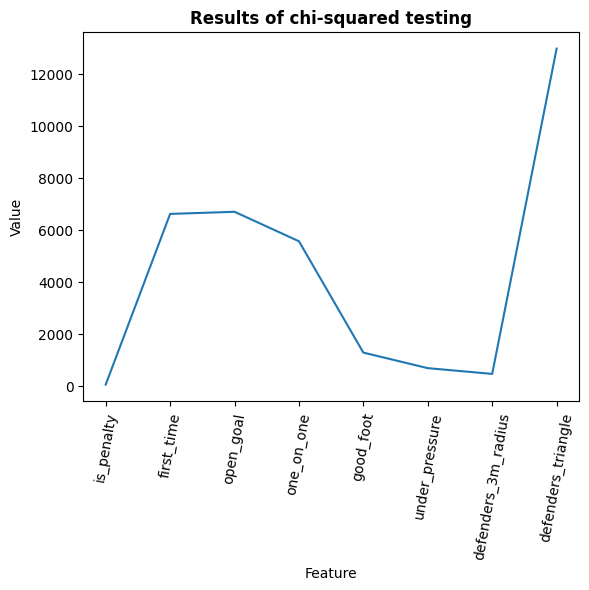

In [11]:
ax = pd.Series([x[1] for x in chi]).plot(xticks=pd.Series([x[0] for x in chi]).index, rot=80)
ax.set_title('Results of chi-squared testing', weight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Value')
_ = ax.set_xticklabels(pd.Series([x[0] for x in chi]))

In [12]:
# Is the number of defenders in the triangle between the shooter and the goal significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['defenders_triangle'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 12964.342765088299
P-value: 0.0
Degrees of freedom: 11


In [13]:
# Is the shooter being on their favoured side significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['good_foot'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 1292.0337511068115
P-value: 6.0870010742934255e-283
Degrees of freedom: 1


In [14]:
# Is the shooter being on their favoured side significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['was_leading'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 3699.912530238936
P-value: 0.0
Degrees of freedom: 2


In [15]:
# We'll use simple linear regression models to investigate how much of the variation in xg can we explain with different sets of features
model = LinearRegression()
model.fit(pd.DataFrame(X_copy['distance_to_goalie']), y1)

# Print coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: 0.21087795326839645
Coefficients: [-0.00692168]


In [16]:
results1 = smf.ols('statsbomb_xg ~ location_x + location_y + goalkeeper_x + goalkeeper_y', data=data).fit()
results2 = smf.ols('statsbomb_xg ~ distance_to_goalie + best_distance + location_x_distance', data=data).fit()
results3 = smf.ols('statsbomb_xg ~ defenders_triangle + defenders_3m_radius', data=data).fit()
results4 = smf.ols('statsbomb_xg ~ shooting_range + best_distance', data=data).fit()
results5 = smf.ols('statsbomb_xg ~ location_y_distance + good_foot', data=data).fit()
results6 = smf.ols('statsbomb_xg ~ distance_to_goalie + best_distance + defenders_triangle + shooting_range + is_header + under_pressure', data=data).fit()

In [17]:
# We can see here that even the simplest, first model accounts for a large amount of variation, while the last model using many of our calculated features, is the best
stargazer_tab = Stargazer([results1, results2, results3, results4, results5, results6])
stargazer_tab

In [18]:
# We can verify our conflusions of our two time-based hypotheses with these two sets of tests
results1 = smf.ols('location_x_distance ~ was_leading', data=data).fit()
results2 = smf.ols('best_distance ~ was_leading', data=data).fit()
results3 = smf.ols('location_x_distance ~ minute', data=data).fit()
results4 = smf.ols('best_distance ~ minute', data=data).fit()

In [19]:
stargazer_tab = Stargazer([results1, results2, results3, results4])
stargazer_tab